# Class Project 2 – Predictive Modeling

The Consumer Financial Protection Bureau (CFPB) is a U.S. government agency that makes sure financial companies treat their customers fairly. Their website allows customers of financial services to file complaints against financial companies and banks against unfair treatment if these companies are unable to resolve complaints to the customer’s satisfaction.
 
When customers choose to complain to the CFPB, financial companies incur additional costs to resolve such complaints.

On receipt, the CFPB routes complaints to the financial companies, who generally respond to the consumer within 15 days.  Once a response is provided, one of two things can happen:

1.	In most cases, consumers accept the response or remediation offered by the financial companies,  
2.	In other cases, they choose to dispute the resolution offered by the company.  (flagged in the 'Consumer disputed?' field).  In these situations, the bank has to perform additional investigations, and possibly offer further relief to the customers.  As a result, the cost of dealing with disputes can be high.  

The original dataset for this project has over 2 million anonymized recent records, and covers 6000+ financial providers of all varieties.  It can be downloaded following the instructions at https://www.consumerfinance.gov/data-research/consumer-complaints/.  The website also provides additional information on the data, including the data dictionary.  

For this project, we will use only the data till 2017, and only for the top 5 banks in the US.  In order to make sure we are all working off the same data, we will use the file complaints_25Nov21.csv available in Jupyterhub under the shared/ folder.  

The cost structure:  
1.	On average, it costs the banks \\$100 to resolve, respond to and close a complaint that is not disputed.  

2.	On the other hand, it costs banks an extra \\$500 to resolve a complaint if it has been disputed.  (This \\$500 is on top of the \\$100 they have already spent.)

3.	Extra diligence: If the banks know in advance which complaints will be disputed, they can perform “extra diligence” during the first round of addressing the complaint with a view to avoiding eventual disputes.  Performing extra diligence costs \\$90 per complaint, and provides a guarantee that the customer will not dispute the complaint.  But performing the extra diligence is wasted money if the customer would not have disputed the complaint.  

You are required to create a model that can help the banks identify complaints that will end in a dispute.  The goal is to minimize total financial costs, and if the banks can identify future disputes they can avoid the larger costs by performing the cheaper extra diligence in advance.  

Hint: Think about Calculating Total Cost in Dollars    
•	The moment a complaint enters the CFPB’s system, there is \\$100 cost to resolve it.  This applies to every complaint.  
•	After that, if a complaint’s resolution is disputed by the customer, an additional \\$500 has to be spent (for a total cost for such cases to be \\$600).  
•	But the bank can intervene in advance by spending an extra \\$90 for extra diligence, and that can make sure the complaint’s resolution is not disputed.    

While we can’t prevent complaints from coming to the CFPB, we can reduce total costs by identifying the complaints that are likely to be disputed, and doing the extra due diligence for them.  This extra due diligence will cost us an extra \\$90 per complaint, but save us the additional \\$500 to resolve the complaint after the dispute.  But obviously, the bank would not want to spend this extra money on complaints that would not have been disputed anyway.  

Your task is to create a predictive model that can help the banks keep their total complaint related costs low.   

Follow the instructions below and answer the multiple choice questions that follow.  


1.	Explore the data, familiarize yourself with the fields and perform some EDA.  

2.	Set your X (predictor) and y (predicted) variables.   
a.	Use only the below variables as your predictors.  Ignore the other variables in the dataset.  

```
'Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',  'Company response to consumer', 'Timely response?'  
```

b.	Use ```'Consumer disputed?'``` as your y-variable.  Be sure to convert your y-variable to 0s and 1s so your model can use it.  

For example, you can use label encoder as below, or any other method you are comfortable using:

```python
from sklearn import preprocessing  
le = preprocessing.LabelEncoder()  
y = le.fit_transform(complaints['Consumer disputed?'])  
```

3.	Split your data into a test and train set.  Use an 80/20 train-test split, and random_state=123 for the train-test split. 

For example, using the below, appropriately adjusted to the variable names you are using:  

```python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)  
```

4.	Check what proportion of complaints in your training dataset are disputed.  If this proportion is less than 30%, use random undersampling with random_state = 123 to balance your dataset.  

For example, you could use the below (adjusted for your choice of variables etc)

```python
from imblearn.under_sampling import RandomUnderSampler  
undersampler = RandomUnderSampler(random_state=123)  
X_train, y_train = undersampler.fit_resample(X, y)  
```

5.	Train a predictive model to predict whether a complaint would be disputed using XGBoost Classifier using random_state=123 

For example, using the below:

```python
model_xgb = XGBClassifier(random_state = 123)
```
  
6.	Evaluate the model on the test set, and create the classification report and confusion matrix.  (Remember, when we say ‘True Positive’, ‘False Negative’ etc, the second word, positive or negative, denotes the ground truth; and the first word, True or False, indicates whether we predicted correctly.) 

7.	Calculate the total cost in dollars for the test set.  Establish the ‘base-case’, ie the total cost if you were not using a model, using the test set only.  

Use the cost structure explained earlier (ie, \\$600 total for every disputed complaint, and \\$100 for every non-disputed complaint, and \\$90 for the extra due diligence.)

8.	Now calculate the total cost in dollars based on the model results in the confusion matrix.  The below graphic might help you.  But you are free to use your own methods.
 
9.	The cost in the default model is not the lowest cost.  Change the classification threshold on the model to calculate the lowest total cost you can achieve.



In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score
from tqdm import tqdm


# Complaints dataset from CFPB  
## Load the data  
First, we load the dataset.  We use the file in the `shared\` folder.

**The dataset for this project is a curated dataset, limited to just the top-5 US banks, and based on information from 2012 to 2017.  In case you are interested in exploring the entire dataset for your own purposes, you can load the data directly from the CFPB website, use the below command.  Be aware you will get lots of data!**
**For this project, you must only use the provided file.**
```python
complaints = pd.read_csv(r'https://files.consumerfinance.gov/ccdb/complaints.csv.zip')
```

In [2]:
# Load dataset from provided file
complaints = pd.read_csv('complaints_25Nov21.csv')

## Review the data
The next few cells look at the data in a couple of different ways.  This does not cover graphing and visualization, but you should consider doing that.

In [3]:
# How many rows and columns do we have?

complaints.shape

(207260, 18)

In [4]:
# What are the column names?

complaints.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [5]:
# Let us look at which banks have the most number of complaints

complaints['Company'].value_counts().sort_values(ascending=False)

Company
BANK OF AMERICA, NATIONAL ASSOCIATION    65440
WELLS FARGO & COMPANY                    53111
JPMORGAN CHASE & CO.                     42170
CITIBANK, N.A.                           34341
U.S. BANCORP                             12198
Name: count, dtype: int64

In [6]:
# Let us get a feel for the data by looking at it

complaints

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,NaN,NaN,JPMORGAN CHASE & CO.,FL,33133,NaN,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10312,NaN,NaN,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,NaN,NaN,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,NaN,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


In [7]:
# How many complaints are disputed by the consumer?

complaints['Consumer disputed?'].value_counts(dropna = False)

Consumer disputed?
No     162357
Yes     44903
Name: count, dtype: int64

In [8]:
# Same thing as a percentage

complaints['Consumer disputed?'].value_counts(normalize=True)

Consumer disputed?
No     0.783349
Yes    0.216651
Name: proportion, dtype: float64

So we have an **imbalanced dataset** as only about 22% is in the `Yes` class.  This means we should consider rebalancing the training dataset using a technique such as SMOTE.  But we will do that after doing the train-test split.  But first, we need to think about what in our data should be the predictor variables, ie, what should be included as a feature in `X`.


In [9]:
# Next, for cleanliness we change the column type for 'Consumer Disputed' from string to category
# We don't have to do this, but can't hurt just in case an algorithm we are trying needs this.

complaints['Consumer disputed?'] = complaints['Consumer disputed?'].astype('category')

In [10]:
# Check out 'Company response to consumer'

complaints['Company response to consumer'].value_counts(dropna=False)

Company response to consumer
Closed with explanation            148930
Closed with monetary relief         22918
Closed with non-monetary relief     19005
Closed without relief               11119
Closed with relief                   2839
Closed                               2274
Untimely response                     175
Name: count, dtype: int64

In [11]:
# Check what does 'Company public response' have

complaints['Company public response'].value_counts(dropna=False)

Company public response
NaN                                                                                                                        148802
Company has responded to the consumer and the CFPB and chooses not to provide a public response                             35858
Company chooses not to provide a public response                                                                            22535
Company believes it acted appropriately as authorized by contract or law                                                       58
Company believes complaint caused principally by actions of third party outside the control or direction of the company         3
Company believes complaint represents an opportunity for improvement to better serve consumers                                  1
Company believes complaint is the result of an isolated error                                                                   1
Company believes complaint relates to a discontinued policy or pro

In [12]:
# Check the 'Submitted via' field

complaints['Submitted via'].value_counts(dropna=False)

Submitted via
Web            115010
Referral        59558
Phone           17530
Postal mail     11506
Fax              3539
Email             117
Name: count, dtype: int64

## Deciding the feature set      
To do that, let us look at the dataset again.  And refer to the data-dictionary in the Word document for the project.  

|Field name  |Description  |
|------------  |------------  |
|Date received  |The date the CFPB received the complaint. For example, “05/25/2013.”  |
|Product  |The type of product the consumer identified in the complaint. For example, “Checking or savings account” or “Student loan.”  |
|Sub-product  |The type of sub-product the consumer identified in the complaint. For example, “Checking account” or “Private student loan.”  |
|Issue  |The issue the consumer identified in the complaint. For example, “Managing an account” or “Struggling to repay your loan.”  |
|Sub-issue  |The sub-issue the consumer identified in the complaint. For example, “Deposits and withdrawals” or “Problem lowering your monthly payments.”  |
|Consumer complaint narrative  |Consumer complaint narrative is the consumer-submitted description of “what happened” from the complaint. Consumers must opt-in to share their narrative. We will not publish the narrative unless the consumer consents, and consumers can opt-out at any time. The CFPB takes reasonable steps to scrub personal information from each complaint that could be used to identify the consumer.  |
|Company public response  |The company’s optional, public-facing response to a consumer’s complaint. Companies can choose to select a response from a pre-set list of options that will be posted on the public database. For example, “Company believes complaint is the result of an isolated error.”  |
|Company  |The complaint is about this company. For example, “ABC Bank.”  |
|State  |The state of the mailing address provided by the consumer.  |
|ZIP code  |The mailing ZIP code provided by the consumer. This field may: i) include the first five digits of a ZIP code; ii) include the first three digits of a ZIP code (if the consumer consented to publication of their complaint narrative); or iii) be blank (if ZIP codes have been submitted with non-numeric values, if there are less than 20,000 people in a given ZIP code, or if the complaint has an address outside of the United States).  |
|Tags  |Data that supports easier searching and sorting of complaints submitted by or on behalf of consumers. For example, complaints where the submitter reports the age of the consumer as 62 years or older are tagged “Older American.” Complaints submitted by or on behalf of a servicemember or the spouse or dependent of a servicemember are tagged “Servicemember.” Servicemember includes anyone who is active duty, National Guard, or Reservist, as well as anyone who previously served and is a veteran or retiree.  |
|Consumer consent provided?  |Identifies whether the consumer opted in to publish their complaint narrative. We do not publish the narrative unless the consumer consents, and consumers can opt-out at any time.  |
|Submitted via  |How the complaint was submitted to the CFPB. For example, “Web” or “Phone.”  |
|Date sent to company  |The date the CFPB sent the complaint to the company.  |
|Company response to consumer  |This is how the company responded. For example, “Closed with explanation.”  |
|Timely response?  |Whether the company gave a timely response. For example, “Yes” or “No.”  |
|Consumer disputed?  |Whether the consumer disputed the company’s response.  **(This is our _y_ variable)**|
|Complaint ID  |The unique identification number for a complaint.  |

We decide to use only a small number of features as predictors for our model.  We will only use the below as predictors.
```
'Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',  'Company response to consumer', 'Timely response?'
```

In [13]:
X = complaints[[ 'Product', 'Sub-product', 'Issue', 'State',  'Tags', 
                'Submitted via',  'Company response to consumer', 'Timely response?']]

## Dealing with missing data  
It is clear that all of these fields that have missing data are categorical, or string, and we cannot use any numerical imputation method to fill the missing values. 

We choose to fill the missing data with a string we will call 'unknown'.

In [14]:
# Check missing values
X.isna().sum()

Product                              0
Sub-product                      43015
Issue                                0
State                             2194
Tags                            178995
Submitted via                        0
Company response to consumer         0
Timely response?                     0
dtype: int64

In [15]:
# Let us fill the missing values with the value 'unknown'
X = X.fillna('unknown')

In [16]:
# Confirm no more missing values.
# The sum of True ISNA() should be zero for all columns

X.isna().sum()

Product                         0
Sub-product                     0
Issue                           0
State                           0
Tags                            0
Submitted via                   0
Company response to consumer    0
Timely response?                0
dtype: int64

## Data prep
We see that there are no cells that have NAs any more after our operations above.  So it is safe to proceed.

In [17]:
# Next, we convert all the X observations into numbers

X = pd.get_dummies(X)


In [18]:
# Let us see what X looks like

print('X has the shape ',X.shape)

X

X has the shape  (207260, 234)


,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Other financial service,Product_Payday loan,Product_Prepaid card,...,Submitted via_Web,Company response to consumer_Closed,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Timely response?_No,Timely response?_Yes
0,False,False,False,False,False,True,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
2,True,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,True
3,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,False,False,False,False,True,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
207256,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
207257,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
207258,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True


**Let us get our _y_ variable**  

In [19]:
y = complaints['Consumer disputed?']

But y contains text, and we need to have 0s and 1s.  We can try to use LabelEncoder to do that

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(complaints['Consumer disputed?'])
print(le.classes_)
labels = dict(zip(list(set(y)), le.inverse_transform(list(set(y)))))
print("\nLabel mapping is:", labels)


['No' 'Yes']

Label mapping is: {0: 'No', 1: 'Yes'}


In [21]:
# Let us now look at what y looks like
# We expect it to be converted to x and y
y

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
# Let us do a value_counts() to check how many of each category.  But we have to convert to a Pandas dataframe first.
print(pd.DataFrame(y).value_counts(), '\n')
print(pd.DataFrame(y).value_counts(normalize=True))

0
0    162357
1     44903
Name: count, dtype: int64 

0
0    0.783349
1    0.216651
Name: proportion, dtype: float64


## Train-test split  
We have our `X` and `y` defined.  Now let us do the train-test split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

Let us look at what our train and test sets look like.

In [24]:
# We check the shape of our X and y 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(165808, 234)
(165808,)
(41452, 234)
(41452,)


In [25]:
X_train

,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Other financial service,Product_Payday loan,Product_Prepaid card,...,Submitted via_Web,Company response to consumer_Closed,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Timely response?_No,Timely response?_Yes
1262,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
141457,False,False,True,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
102396,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
70019,False,False,False,False,False,False,True,False,False,False,...,True,False,True,False,False,False,False,False,False,True
113979,False,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119906,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
192476,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
17730,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
28030,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True


## Q1 
In the test set (not the entire dataset), what proportion of consumers raised a dispute?

In [26]:
pd.DataFrame(y_test).value_counts(normalize = True)

0
0    0.784136
1    0.215864
Name: proportion, dtype: float64

In [27]:
X_test

,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Other financial service,Product_Payday loan,Product_Prepaid card,...,Submitted via_Web,Company response to consumer_Closed,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Timely response?_No,Timely response?_Yes
176548,False,False,True,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
48967,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
81483,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
8848,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
8282,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509,False,False,False,False,False,False,True,False,False,False,...,True,False,True,False,False,False,False,False,False,True
70176,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True
77933,False,False,False,False,False,False,True,False,False,False,...,True,False,True,False,False,False,False,False,False,True
39045,False,False,True,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True


In [28]:
pd.DataFrame(y_train).value_counts(normalize = True)

0
0    0.783153
1    0.216847
Name: proportion, dtype: float64

## Dealing with imbalanced data  
Since we have an imbalanced dataset, we should try to do something to oversample the minority category, or undersample the majority.  

### Random Undersampling

In [29]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=123)
X_train, y_train = undersampler.fit_resample(X, y)

In [30]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [31]:
# Let us check if the dataset is balanced
# just checking that the '1' category is exactly 50% of the training set

y_train.sum()/len(y_train) 

0.5

## Q2
After you have performed random undersampling, what proportion of consumers in the training dataset raised a dispute?

We can use the answer from the previous cell, or use the same method that we used before.

In [32]:
pd.DataFrame(y_train).value_counts(normalize=True)

0
0    0.5
1    0.5
Name: proportion, dtype: float64

In [33]:
X_train.shape

(89806, 234)

In [34]:
# Let us look at what y_train looks like, and the value_counts()
pd.DataFrame(y_train).value_counts()

0
0    44903
1    44903
Name: count, dtype: int64

In [35]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(207260, 234)
(89806, 234)
(41452, 234)


**Now everything is set up, we have X_train, y_train, X_test, y_test and a perfectly balanced dataset.  We can now feed it to a model of our choice, and look at the results.**  

## Fit a model using XGBoost

In [36]:
%%time
# Fit the model
from xgboost import XGBClassifier

model_xgb = XGBClassifier(random_state = 123)
model_xgb.fit(X_train, y_train)

CPU times: user 9.11 s, sys: 267 ms, total: 9.38 s
Wall time: 6.84 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [37]:
# Perform predictions, and store the results in a variable called 'pred'
pred = model_xgb.predict(X_test)

              precision    recall  f1-score   support

          No       0.85      0.53      0.66     32504
         Yes       0.28      0.65      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.56      0.59      0.52     41452
weighted avg       0.73      0.56      0.60     41452



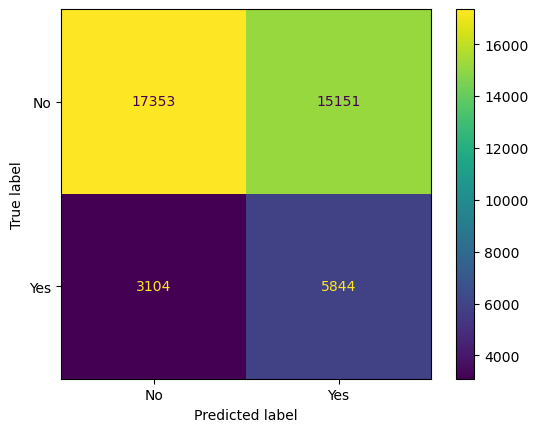

In [38]:
# Check the classification report and the confusion matrix

print(classification_report(y_true = y_test, y_pred = pred, target_names=le.classes_))

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test, display_labels=le.classes_, values_format='');

## Q3
Fit the XGBClassifier model as described in the instructions, and evaluate it on the test set.  What is the recall for the category 'Consumer disputed?' = 'Yes' on the test set?

**Answer**: As above in the classification report, the recall for the 'Yes' category on the test set is 0.65

## Calculating Total Cost in Dollars    
The confusion matrix has 4 cells.  Each one has a different 'cost'.  Let us look at each:

> First cell (yellow cell, 1st row, 1st col): True NoDispute: Model predicted NoDispute, and customer did not dispute either.
> Here, we know we will pay $100 as "On average, it costs the banks \\$100 to resolve, respond to and close a complaint that is not disputed".

> Second cell (green cell, 1st row 2nd col): False Dispute: Model predicted Dispute and customer did not dispute.
> Here, we will end up investigating and performing additional due diligence at the cost of \\$90 over and above the $100 that has to be spent in any case.  So the cost of the entries in this cell are \\$190.

> Third cell (purple cell, 2nd row 1st col): False NoDispute: Model predicted NoDispute, but customer disputed.
> Here we will spend an extra \\$500 in addition to the \\$100, so there will be a total cost of \\$600.

> Fourth cell (blue cell, 2nd row, 2nd col): Model predicted Dispute, and customer actually disputed too.  
> Here we will spend the \\$90 for the cost of additional due diligence over and above the \\$100 that needs to be spent anyway.  So the total cost of any cases in this cell will be \\$190

Let us calculate the total cost based on our confusion matrix.  The confusion matrix has the false positives and the false negatives in the cells outside the main diagonal.  

**Establishing the base case**  
**Total cost for test set**  

Let us calculate the total cost to the banks in the absence of any model.  The complaints are what they are, and the costs are what they are too.  Any regular complaint costs \\$100, and any disputed complaint costs \\$600.

## Q4 
If there were no model, what would be the total cost to the banks of dealing with the complaints in the test set?

We look at the total number of complaints in the test set that are disputed and those that are not disputed, and multiply each by their respective costs (\\$600 and \\$100)

In [39]:
pd.DataFrame(y_test).value_counts()

0
0    32504
1     8948
Name: count, dtype: int64

Class 0, or no dispute, costs \\$100 and Class 1, or dispute=yes costs\\$600.  So the total cost is as below.

In [40]:
32504*100 + 8948*600

8619200

In [41]:
# Or formatted nicely using a Python f-string
print(f'${32504*100 + 8948*600:,}')

$8,619,200


In [42]:
# Let us see the cost for all data, and for the training data:

In [43]:
# Training data
pd.DataFrame(y_train).value_counts()[0] * 100 + pd.DataFrame(y_train).value_counts()[1] * 600

31432100

In [44]:
# All data
pd.DataFrame(y).value_counts()[0] * 100 + pd.DataFrame(y).value_counts()[1] * 600

43177500

## Q5
Use the predictions for which complaints are likely to be disputed from the model you have created.  Assume that if the model predicts a complaint will be disputed, the banks decide to spend \\$90 performing extra diligence to avoid the \\$600 cost of a dispute.

In this situation based on model results, what would be the total cost to the banks of dealing with the complaints in the test set?

**Answer**: We use the confusion matrix we had calculated earlier.  To each cell, we apply the cost associated with that cell and add them up.

In [45]:
# Recall the confusion matrix from the prior cell

cm

array([[17353, 15151],
       [ 3104,  5844]])

In [46]:
# Cost when model predicts dispute and actually disputed
True_NoDispute_Cost = 100 * cm[0, 0]

# Cost when model predicts dispute and no actual dispute 
False_Dispute_Cost = 190 * cm[0,1]

# Cost when model predicts NoDispute and actually disputed
False_NoDispute_Cost = 600 * cm[1,0]

# Cost when model predicts NoDispute correctly
True_Dispute_Cost = 190 * cm[1,1]

In [47]:
Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
Total_cost
print(f'$ {Total_cost:,}' )

$ 7,586,750


## Adjusting the threshold  

We are able to obtain the probability for a complaint being a "1" (which means 'yes').  The default is generally 0.5, which means if the probability of something being a dispute is more than 0.5, we consider it as 'yes', and if the prob is <0.5, we consider it a 'no'.  But we can change this threshold because we are very interested in finding future disputes even if we end up with more false positives.  This means we can play with the 0.5 threshold.  

On average, it costs the banks \\$100 to resolve, respond to and close a complaint that is not disputed .  On the other hand, it costs banks an extra \\$500 to resolve a complaint if it has been disputed.  

Our goal is to create and evaluate a predictive model that can help the banks identify future disputes so they can perform “extra diligence” during the first round of addressing the complaint with a view to avoiding eventual disputes.  If a complaint is picked up for “extra diligence”, it costs the bank an extra \\$90 to perform the additional diligence steps.  

It is clear that the cost of extra diligence is very low (\\$90), but if a complaint reaches the dispute stage, the cost can get quite high (\\$500).  So we would like to reduce false negatives from our predictive model, even if it means we push up false positives.  That is because the cost of false positives is quite low compared to the cost of false negatives.  

This means we want high recall, and are okay with a lower precision.  

**This means we can play around with the threshold that decides what is marked as 'yes'.  Feel free to reduce this threshold on the next cell, and see if it helps you get better recall for category 1 (that may reduce accuracy, but that is okay).**   

Let us lower the threshold to a different value and see what happens to our confusion matrix, and if we can lower our total cost.

In [48]:
# Look at how the probabilities look for the first 10 observations
# The first column is class 0, and the second column is class 1

model_xgb.predict_proba(X_test)[:10]

array([[0.34525168, 0.6547483 ],
       [0.55318874, 0.44681126],
       [0.53836995, 0.46163005],
       [0.82460964, 0.17539038],
       [0.6356379 , 0.36436215],
       [0.4250173 , 0.5749827 ],
       [0.45215088, 0.5478491 ],
       [0.46450043, 0.5354996 ],
       [0.44814914, 0.55185086],
       [0.46196222, 0.5380378 ]], dtype=float32)

In [49]:
# Now see what the actual prediction is for the first 10 items
# You can see the model has picked the most probable item
# for identifying which category it should be assigned.
#
# We can vary the threshold to change the predictions.
# We do this next

model_xgb.predict(X_test)[:10]

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1])

Confusion Matrix : 
 [[17353 15151]
 [ 3104  5844]]
Test accuracy =  0.5596111164720641
              precision    recall  f1-score   support

          No       0.85      0.53      0.66     32504
         Yes       0.28      0.65      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.56      0.59      0.52     41452
weighted avg       0.73      0.56      0.60     41452



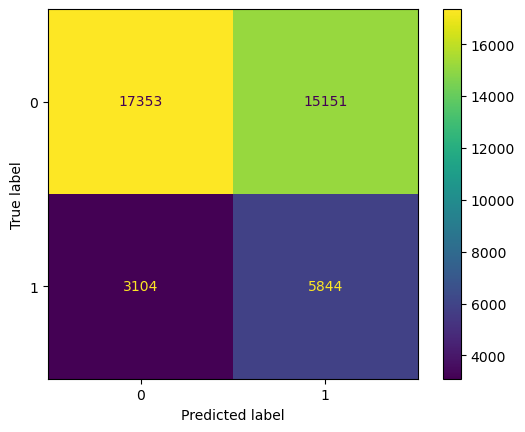

In [50]:
# Set threshold for identifying class 1
threshold = 0.5

# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred, target_names=le.classes_))

So we see that recall has gone up to 90% from a lower number earlier.

**Calculating Total Cost in Dollars**  

Let us calculate the total cost based on our confusion matrix.  Just like we did before, no change to the logic.

In [51]:
# Cost when model predicts dispute and actually disputed
True_NoDispute_Cost = 100 * cm[0, 0]

# Cost when model predicts dispute and no actual dispute 
False_Dispute_Cost = 190 * cm[0,1]

# Cost when model predicts NoDispute and actually disputed
False_NoDispute_Cost = 600 * cm[1,0]

# Cost when model predicts NoDispute correctly
True_Dispute_Cost = 190 * cm[1,1]

In [52]:
Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
f'${Total_cost:,}'

'$7,586,750'

# Optimal value for threshold
Now you can see how you can play around with the threshold and change your total cost.  In fact, you could create a loop to go through many possibiities of thresholds and find out the optimal threshold that leads to the minimum cost.  

We do that in the next cell, running predictions by using the threshold value to be every value between 0 and 1 in increments of 0.01.  See that I use the library `tqdm` to get a nice looking progress bar at the bottom.  

100%|██████████| 100/100 [00:26<00:00,  3.83it/s]

CPU times: user 40.4 s, sys: 1.07 s, total: 41.5 s
Wall time: 26.3 s


<Axes: xlabel='threshold', ylabel='Total_cost'>

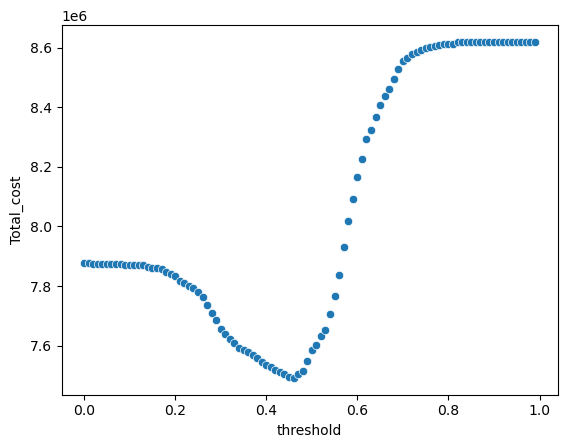

In [53]:
%%time
# Set threshold for identifying class 1
threshold = 0.0001
appended_data = []

for threshold in tqdm(np.arange(0,1,.01)):
    # Create predictions.  Note that predictions give us probabilities, not classes!
    pred_prob = model_xgb.predict_proba(X_test)

    # We drop the probabilities for class 0, and keep just the second column
    pred_prob = pred_prob[:,1]

    # Convert probabilities to 1s and 0s based on threshold
    pred = (pred_prob>threshold).astype(int)

    # confusion matrix
    cm = confusion_matrix(y_test, pred)
    
    # accuracy score of the model
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred,zero_division=0)
    recall = recall_score(y_test, pred)
    
    # Cost when model predicts dispute and actually disputed
    True_NoDispute_Cost = 100 * cm[0, 0]

    # Cost when model predicts dispute and no actual dispute 
    False_Dispute_Cost = 190 * cm[0,1]

    # Cost when model predicts NoDispute and actually disputed
    False_NoDispute_Cost = 600 * cm[1,0]

    # Cost when model predicts NoDispute correctly
    True_Dispute_Cost = 190 * cm[1,1]
    
    Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
    Total_cost
    
    data = pd.DataFrame({'threshold':[threshold], 'accuracy': [accuracy], 
                         'precision':[precision], 'recall':[recall],
                         'True_NoDispute_Cost':[True_NoDispute_Cost], 
                         'False_Dispute_Cost':[False_Dispute_Cost], 
                         'False_NoDispute_Cost':[False_NoDispute_Cost],
                         'True_Dispute_Cost':[True_Dispute_Cost],
                         'Total_cost':[Total_cost]})
    appended_data.append(data)
    
    

appended_data = pd.concat(appended_data)    

appended_data.reset_index()

# appended_data.to_excel('temp.xlsx')
sns.scatterplot(data = appended_data, y = 'Total_cost', x = 'threshold')

## Q6
The costs to the banks from doing due diligence and from having disputes are asymmetrical.  Therefore you have the opportunity to reduce total cost by varying the probability threshold from the default 0.5 in a binary classification situation as this.

Change the value of the threshold and determine the lowest total cost to the banks based on the observations in the test set.

## Q7 
At what value of the threshold is the lowest dollar cost achieved?
    
**Answer**: We have done this above, all we need to do is to figure out the minimum point in the graph above.  This happens in the next cell.  You can see the best value of the threshold is 0.46, and the lowest total cost is $ 7,491,540

In [54]:
# At this point I can review the dataframe appended_data to find out the best threshold for minimizing cost
# Or I can do a simple query to list only the row that has the minumum cost by asking for
# appended_data[appended_data.Total_cost == appended_data.Total_cost.min()]
# I add some transpose and rounding to make it easier to read.

print(round(appended_data[appended_data.Total_cost == appended_data.Total_cost.min()].transpose(),3))

                                0
threshold                   0.460
accuracy                    0.457
precision                   0.260
recall                      0.820
True_NoDispute_Cost   1161400.000
False_Dispute_Cost    3969100.000
False_NoDispute_Cost   967200.000
True_Dispute_Cost     1393840.000
Total_cost            7491540.000


Confusion Matrix : 
 [[11614 20890]
 [ 1612  7336]]
Test accuracy =  0.4571552639197144
              precision    recall  f1-score   support

          No       0.88      0.36      0.51     32504
         Yes       0.26      0.82      0.39      8948

    accuracy                           0.46     41452
   macro avg       0.57      0.59      0.45     41452
weighted avg       0.74      0.46      0.48     41452



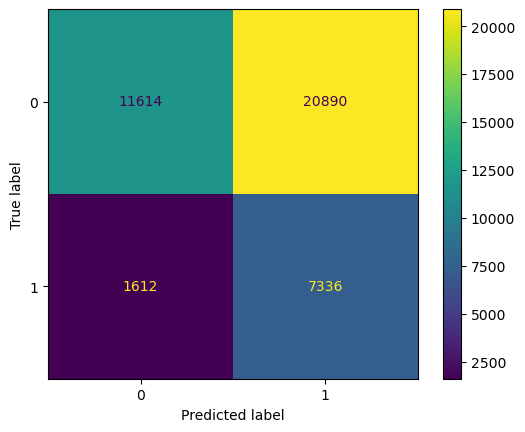

In [55]:
# Set threshold for identifying class 1
threshold = 0.46

# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred, target_names=le.classes_))

**Again - Calculating Total Cost in Dollars at the lowest threshold**  

Let us calculate the total cost based on our confusion matrix above.  Just like we did before, no change to the logic.

In [56]:
# Cost when model predicts dispute and actually disputed
True_NoDispute_Cost = 100 * cm[0, 0]

# Cost when model predicts dispute and no actual dispute 
False_Dispute_Cost = 190 * cm[0,1]

# Cost when model predicts NoDispute and actually disputed
False_NoDispute_Cost = 600 * cm[1,0]

# Cost when model predicts NoDispute correctly
True_Dispute_Cost = 190 * cm[1,1]

In [57]:
Total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
f'${Total_cost:,}'

'$7,491,540'

So my minimum cost occurs at a threshold of 0.46, and the cost is ~$7.5 mm.


## END